# Creating Helper Functions

In [1]:
import sqlite3 as sq
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

def run_query(q):
    with sq.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with sq.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = 'SELECT\
                name,\
                type\
         FROM sqlite_master\
         WHERE type IN("table","view");'
    return run_query(q)

In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Analysing Sales per Genre in the US

In [3]:
q_genre_purchased = "\
 WITH\
     all_purchases AS        \
         (                   \
         SELECT              \
            invoice_id,      \
            billing_country  \
         FROM invoice        \
        ),                   \
                             \
      il_all_purchases AS    \
        (                    \
        SELECT               \
            *                \
        FROM invoice_line il \
        INNER JOIN all_purchases ap ON ap.invoice_id = il.invoice_id\
        ),                   \
                             \
      track_il_purchases AS  \
          (                  \
           SELECT            \
               ilp.*,        \
               t.genre_id    \
           FROM track t      \
           INNER JOIN il_all_purchases ilp ON ilp.track_id = t.track_id\
          ),                 \
                             \
       genre_il_purchases AS \
           (                 \
            SELECT           \
                g.name genre, \
                t.billing_country country\
            FROM track_il_purchases t     \
            INNER JOIN genre g ON g.genre_id = t.genre_id\
           )                 \
                             \
    SELECT\
        genre,               \
        country,             \
        COUNT(*) total_purchase\
    FROM genre_il_purchases  \
    WHERE country = 'USA'    \
    GROUP BY 1, 2            \
    ORDER BY 3 DESC          "
genre_sales_usa= run_query(q_genre_purchased)
genre_sales_usa

,genre,country,total_purchase
0,Rock,USA,561
1,Alternative & Punk,USA,130
2,Metal,USA,124
3,R&B/Soul,USA,53
4,Blues,USA,36
5,Alternative,USA,35
6,Latin,USA,22
7,Pop,USA,22
8,Hip Hop/Rap,USA,20
9,Jazz,USA,14


In [4]:
genre_sales_usa.set_index('genre', inplace= True, drop=True)

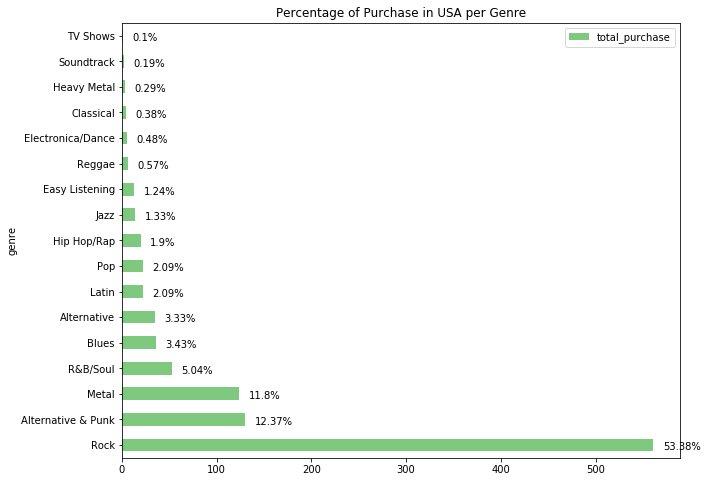

In [5]:
def c_per(sale):
    g_sum = genre_sales_usa['total_purchase'].sum()
    per_n = (sale/g_sum) *100
    per = round(per_n, 2)
    return per

genre_sales_usa['per'] = genre_sales_usa['total_purchase'].apply(c_per)



genre_sales_usa.plot(
    kind='barh', 
    title = "Percentage of Purchase in USA per Genre", 
    figsize=(10,8), 
    y='total_purchase',
    colormap=plt.cm.Accent
                    )

for i, label in enumerate(list(genre_sales_usa.index)):
    g_sold = genre_sales_usa.loc[label, 'total_purchase']
    g_per = str(genre_sales_usa.loc[label,'per']) + "%"
    plt.annotate(g_per, (g_sold + 10, i-0.2))

From our given list:

    1- Hip-Hop
    
    2- Punk
    
    3- Pop
    
    4- Blues

and from our analysis of sales in the US, the above genre rank as follows:

    1- Punk    with  12.3%
    
    2- Blues   with   3.43%
    
    3- Pop     with   2.09%
    
    4- Hip-Hop with   1.9%
    
The data shows that the store should buy the albums from the following artists on a considerable weight of their sales:

    1- Red Tone
    
    2- Slim Jim Bites
    
    3- Meteor and the Girls

In [6]:
q_col_t =" PRAGMA table_info(employee) "
col_t = run_query(q_col_t)
col_t

,cid,name,type,notnull,dflt_value,pk
0,0,employee_id,INTEGER,1,None,1
1,1,last_name,NVARCHAR(20),1,None,0
2,2,first_name,NVARCHAR(20),1,None,0
3,3,title,NVARCHAR(30),0,None,0
4,4,reports_to,INTEGER,0,None,0
5,5,birthdate,DATETIME,0,None,0
6,6,hire_date,DATETIME,0,None,0
7,7,address,NVARCHAR(70),0,None,0
8,8,city,NVARCHAR(40),0,None,0
9,9,state,NVARCHAR(40),0,None,0


# Analysing employee performance with sales total per each

In [7]:
q_emp ="             \
        SELECT\
            *\
        FROM employee\
        LIMIT 2"
emp_df = run_query(q_emp)
emp_df

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com


In [8]:
q_emp ="                                                                \
        WITH                                                            \
            supervisor AS                                               \
                (                                                       \
                 SELECT                                                 \
                     employee_id,                                       \
                     first_name || ' ' || last_name supervisor_name,    \
                     title s_title,                                     \
                     reports_to,                                        \
                     birthdate s_birthdate,                             \
                     hire_date s_hiredate,                              \
                     address s_address,                                 \
                     postal_code s_postalcode                           \
                  FROM employee                                         \
                ),                                                      \
                                                                        \
             c_tot_pur AS                                               \
                 (                                                      \
                  SELECT                                                \
                    c.support_rep_id,                                   \
                    c.customer_id,                                      \
                    SUM(i.total) customer_tot_purchase                  \
                  FROM customer c                                       \
                  INNER JOIN invoice i ON i.customer_id = c.customer_id \
                  GROUP BY 2                                            \
                 ),                                                     \
                                                                        \
             e_c AS                                                     \
                 (                                                      \
                  SELECT                                                \
                      *                                                 \
                  FROM employee e                                       \
                  LEFT JOIN c_tot_pur c                                 \
                  ON c.support_rep_id = e.employee_id                   \
                 )                                                      \
                                                                        \
        SELECT                                                          \
          first_name || ' ' || last_name employee_name,                 \
          title,                                                        \
          SUM(customer_tot_purchase) Total_purchase_per_employee,       \
          hire_date                                                     \
        FROM e_c                                                        \
        GROUP BY employee_id                                            \
                 "
emp_df = run_query(q_emp)
emp_df

,employee_name,title,Total_purchase_per_employee,hire_date
0,Andrew Adams,General Manager,NaN,2016-08-14 00:00:00
1,Nancy Edwards,Sales Manager,NaN,2016-05-01 00:00:00
2,Jane Peacock,Sales Support Agent,1731.51,2017-04-01 00:00:00
3,Margaret Park,Sales Support Agent,1584.00,2017-05-03 00:00:00
4,Steve Johnson,Sales Support Agent,1393.92,2017-10-17 00:00:00
5,Michael Mitchell,IT Manager,NaN,2016-10-17 00:00:00
6,Robert King,IT Staff,NaN,2017-01-02 00:00:00
7,Laura Callahan,IT Staff,NaN,2017-03-04 00:00:00


Only the Sales Support Agents are the ones that have customers.

Other employees do not have direct sales.

In [9]:
emp_df = emp_df.dropna()
emp_df

,employee_name,title,Total_purchase_per_employee,hire_date
2,Jane Peacock,Sales Support Agent,1731.51,2017-04-01 00:00:00
3,Margaret Park,Sales Support Agent,1584.00,2017-05-03 00:00:00
4,Steve Johnson,Sales Support Agent,1393.92,2017-10-17 00:00:00


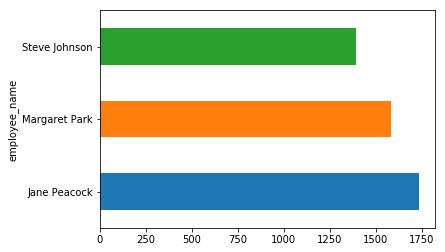

In [77]:
emp_df.plot(kind='barh',
            x= 'employee_name',
            y='Total_purchase_per_employee',
            #x_label='Total sales per employee in dollars',
            legend= False)

Jane seems to be the top sales person. But this can be correlated to her hire date.

The employees are hired in the following order:

Jane --> Margret --> Steve

Therefore, the difference in sales is as far as the analysis go is a function of time

## Analysing if companies make a difference in the sales per employee

In [71]:
q_c = "                                                                  \
       WITH                                                              \
        tot_per_cust AS                                                  \
           (                                                             \
           SELECT                                                        \
                c.support_rep_id,                                        \
                c.company,                                               \
                SUM(total) purchase_total                                \
           FROM customer c                                               \
           INNER JOIN invoice i ON i.customer_id = c.customer_id         \
           GROUP BY i.invoice_id                                         \
           )                                                             \
        SELECT                                                           \
            e.first_name || ' ' || e.last_name employee_name,            \
            tc.company,                                                  \
            SUM(purchase_total) Purchase_per_customer                    \
        FROM employee e                                                  \
        INNER JOIN tot_per_cust tc ON tc.support_rep_id = e.employee_id  \
        GROUP BY 1, 2\
        "
c_tot = run_query(q_c)
c_tot


,employee_name,company,Purchase_per_customer
0,Jane Peacock,None,1419.66
1,Jane Peacock,Apple Inc.,54.45
2,Jane Peacock,Embraer - Empresa Brasileira de Aeronáutica S.A.,108.90
3,Jane Peacock,Riotur,82.17
4,Jane Peacock,Rogers Canada,66.33
5,Margaret Park,None,1304.82
6,Margaret Park,Google Inc.,74.25
7,Margaret Park,JetBrains s.r.o.,144.54
8,Margaret Park,Woodstock Discos,60.39
9,Steve Johnson,None,1196.91


In [72]:
c_tot.set_index('company', inplace= True, drop= True)
c_tot

,employee_name,Purchase_per_customer
company,,
NaN,Jane Peacock,1419.66
Apple Inc.,Jane Peacock,54.45
Embraer - Empresa Brasileira de Aeronáutica S.A.,Jane Peacock,108.90
Riotur,Jane Peacock,82.17
Rogers Canada,Jane Peacock,66.33
NaN,Margaret Park,1304.82
Google Inc.,Margaret Park,74.25
JetBrains s.r.o.,Margaret Park,144.54
Woodstock Discos,Margaret Park,60.39


In [73]:
for each in c_tot.index:
    if each is None:
        c_tot['company'] = 'Misc.'

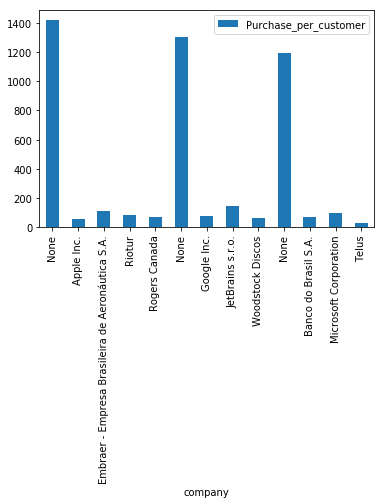

In [67]:
c_tot.plot(kind= 'bar')

It seams that whether a company is a customer or not, does not have an impact on sales of any rep.

# Analysing sales per country

In [93]:
c ='''
    CREATE VIEW c1_country AS
        SELECT
            country,
            COUNT(*) count
        FROM customer
        GROUP BY 1
'''

run_command(c)

In [161]:
qc ='''
        WITH
        
            other_country AS
            (
             SELECT
                 CASE
                     WHEN
                     (
                         SELECT count(*)
                         FROM customer
                         WHERE country = c.country
                     )= 1 THEN "Other"
                     ELSE c.country
                     END AS country,
                 COUNT(c.customer_id) no_of_customers,
                 SUM(i.total) total_in_dollars,
                 (SUM(i.total)/COUNT(DISTINCT c.customer_id)) avg_per_cust,
                 AVG(i.total) avg_sales_per_order
             FROM customer c
             INNER JOIN invoice i ON i.customer_id = c.customer_id
             GROUP BY country
        )
SELECT 
    *,
    CASE
        WHEN country = "Other" THEN 1
        ELSE 0
        END AS sort
FROM other_country
GROUP BY country
ORDER BY sort DESC
'''
country_metrics = run_query(qc)
country_metrics

,country,no_of_customers,total_in_dollars,avg_per_cust,avg_sales_per_order,sort
0,Other,10,75.24,75.240000,7.524000,1
1,Brazil,61,427.68,85.536000,7.011148,0
2,Canada,76,535.59,66.948750,7.047237,0
3,Czech Republic,30,273.24,136.620000,9.108000,0
4,France,50,389.07,77.814000,7.781400,0
5,Germany,41,334.62,83.655000,8.161463,0
6,India,21,183.15,91.575000,8.721429,0
7,Portugal,29,185.13,92.565000,6.383793,0
8,USA,131,1040.49,80.037692,7.942672,0
9,United Kingdom,28,245.52,81.840000,8.768571,0


In [162]:
country_metrics.set_index('country', inplace= True, drop= True)

In [163]:
country_metrics

,no_of_customers,total_in_dollars,avg_per_cust,avg_sales_per_order,sort
country,,,,,
Other,10,75.24,75.240000,7.524000,1
Brazil,61,427.68,85.536000,7.011148,0
Canada,76,535.59,66.948750,7.047237,0
Czech Republic,30,273.24,136.620000,9.108000,0
France,50,389.07,77.814000,7.781400,0
Germany,41,334.62,83.655000,8.161463,0
India,21,183.15,91.575000,8.721429,0
Portugal,29,185.13,92.565000,6.383793,0
USA,131,1040.49,80.037692,7.942672,0
